$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [45]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [46]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/tal.yaakov/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/tal.yaakov/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [47]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


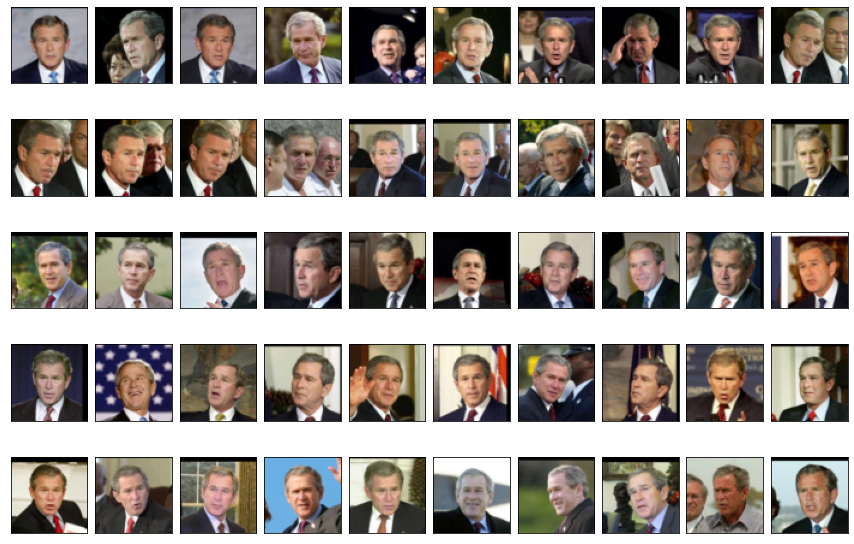

In [48]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [49]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [50]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Dropout(p=0.3, inplace=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): Dropout(p=0.3, inplace=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Dropout(p=0.3, inplace=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=64, stride=64, padding=0, dilation=1, ceil_mode=False)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [51]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.6, inplace=False)
    (3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(4, 4))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.6, inplace=False)
    (6): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(4, 4))
    (7): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [52]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [53]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223, dtype=torch.float64)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

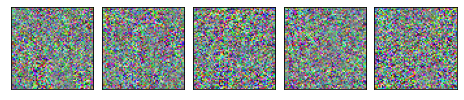

In [54]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [62]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 64, 'z_dim': 256, 'data_label': 1, 'label_noise': 0.25, 'discriminator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'weight_decay': 0.015, 'betas': (0.5, 0.999), 'lr': 0.0002}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 2.1417469448513455
Generator loss:     0.14013023977802963


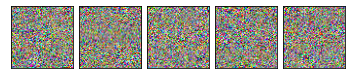

--- EPOCH 2/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
Discriminator loss: 1.8571602635913425
Generator loss:     0.18921312494691817


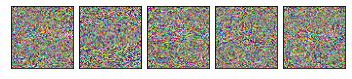

--- EPOCH 3/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 1.7036596801545885
Generator loss:     0.21771724685412946


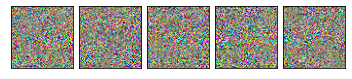

--- EPOCH 4/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
Discriminator loss: 1.5776719517178006
Generator loss:     0.24298389582892999


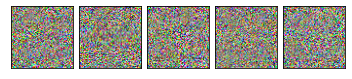

--- EPOCH 5/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 1.52722520298428
Generator loss:     0.2618299292847354


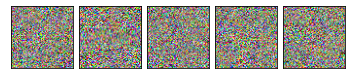

--- EPOCH 6/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
Discriminator loss: 1.4609295792049832
Generator loss:     0.282205829323877


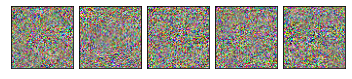

--- EPOCH 7/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 1.410640345679389
Generator loss:     0.29954882906164537


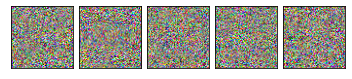

--- EPOCH 8/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.10it/s]
Discriminator loss: 1.3785353501637776
Generator loss:     0.3147240553155659


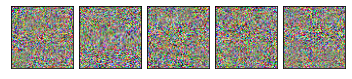

--- EPOCH 9/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
Discriminator loss: 1.3154943916532729
Generator loss:     0.3309942420375666


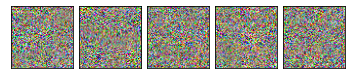

--- EPOCH 10/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 1.28568520810869
Generator loss:     0.3481158289007591


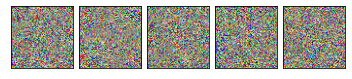

--- EPOCH 11/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.15it/s]
Discriminator loss: 1.218027737405565
Generator loss:     0.36419296128588896


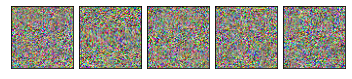

--- EPOCH 12/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 1.1913944615258112
Generator loss:     0.37754569469735944


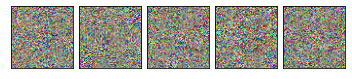

--- EPOCH 13/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 1.1674052609337702
Generator loss:     0.39056681410208605


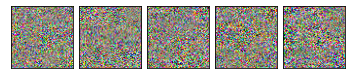

--- EPOCH 14/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 1.1474971638785467
Generator loss:     0.4072776605477727


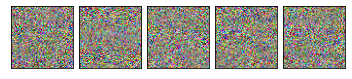

--- EPOCH 15/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 1.0870025422837999
Generator loss:     0.42356654845092057


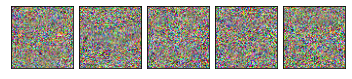

--- EPOCH 16/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 1.0849700172742207
Generator loss:     0.44096300088990775


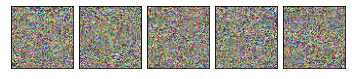

--- EPOCH 17/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 1.045173380109999
Generator loss:     0.45661974261246807


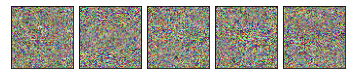

--- EPOCH 18/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.9773694541719224
Generator loss:     0.47048236154737505


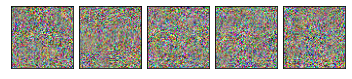

--- EPOCH 19/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 0.9956135418679979
Generator loss:     0.4802687869049802


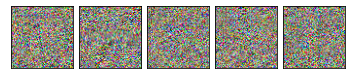

--- EPOCH 20/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 0.9701973530981276
Generator loss:     0.4987871074928949


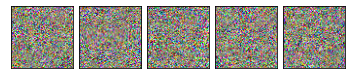

--- EPOCH 21/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.947791854540507
Generator loss:     0.5138647395063443


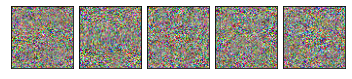

--- EPOCH 22/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 0.9173769222365485
Generator loss:     0.529268699994262


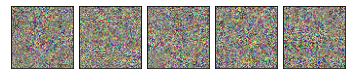

--- EPOCH 23/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.892829418182373
Generator loss:     0.5409874488288653


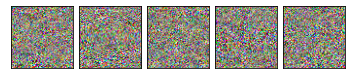

--- EPOCH 24/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
Discriminator loss: 0.8962182336383395
Generator loss:     0.5561536734119333


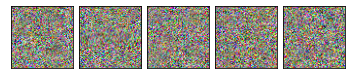

--- EPOCH 25/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.871685610877143
Generator loss:     0.5689731961566721


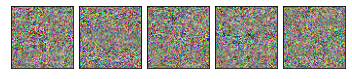

--- EPOCH 26/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
Discriminator loss: 0.8322665558920966
Generator loss:     0.5803321241653953


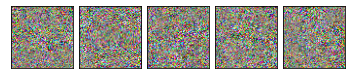

--- EPOCH 27/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.8180279731750488
Generator loss:     0.5950153253967363


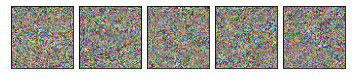

--- EPOCH 28/100 ---
100%|██████████| 9/9 [00:01<00:00,  4.51it/s]
Discriminator loss: 0.8097439408302307
Generator loss:     0.6067330903599564


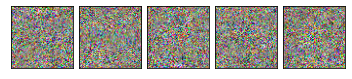

--- EPOCH 29/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.7918478714095222
Generator loss:     0.6212243052172483


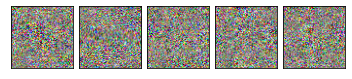

--- EPOCH 30/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.7830256356133355
Generator loss:     0.6327632143178387


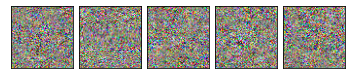

--- EPOCH 31/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.11it/s]
Discriminator loss: 0.7959360347853767
Generator loss:     0.6420679626446536


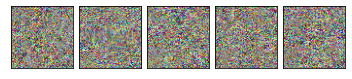

--- EPOCH 32/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.7668609619140625
Generator loss:     0.6561341162338574


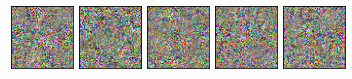

--- EPOCH 33/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.7497804164886475
Generator loss:     0.6678274567334286


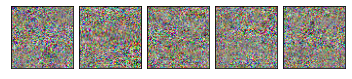

--- EPOCH 34/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.7147040963172913
Generator loss:     0.6779622113337866


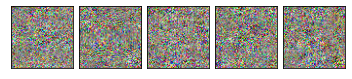

--- EPOCH 35/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.7166799902915955
Generator loss:     0.6875538719621752


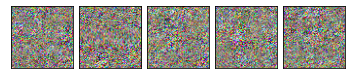

--- EPOCH 36/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.6940992871920267
Generator loss:     0.6991879453358031


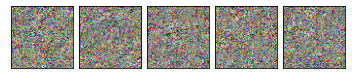

--- EPOCH 37/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 0.7075792882177565
Generator loss:     0.7135967731663526


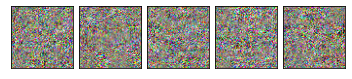

--- EPOCH 38/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.94it/s]
Discriminator loss: 0.6734157204627991
Generator loss:     0.7211934127199385


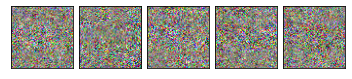

--- EPOCH 39/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.31it/s]
Discriminator loss: 0.6375561753908793
Generator loss:     0.7379054011209955


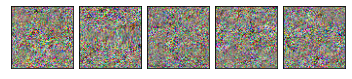

--- EPOCH 40/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.6777529451582167
Generator loss:     0.745756194986457


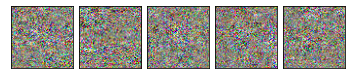

--- EPOCH 41/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 0.64002925157547
Generator loss:     0.7603500295732315


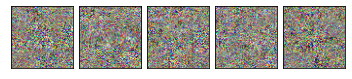

--- EPOCH 42/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.6373397906621298
Generator loss:     0.7717000171605898


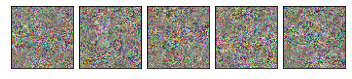

--- EPOCH 43/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
Discriminator loss: 0.6381954153378805
Generator loss:     0.782621220539505


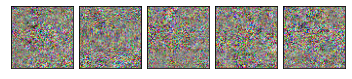

--- EPOCH 44/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 0.5946662889586555
Generator loss:     0.7974325465372221


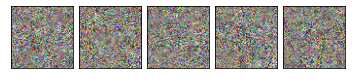

--- EPOCH 45/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
Discriminator loss: 0.5813165108362833
Generator loss:     0.8109143066289415


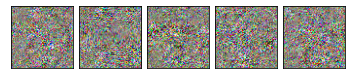

--- EPOCH 46/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.5714177721076541
Generator loss:     0.8223143814253328


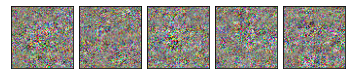

--- EPOCH 47/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.36it/s]
Discriminator loss: 0.5857722494337294
Generator loss:     0.836416762636436


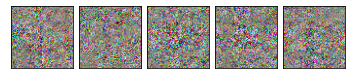

--- EPOCH 48/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.5600631501939561
Generator loss:     0.8537688532141758


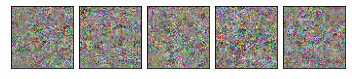

--- EPOCH 49/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
Discriminator loss: 0.5445092618465424
Generator loss:     0.8673667956919362


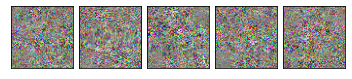

--- EPOCH 50/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.5394492579831017
Generator loss:     0.8769581199208543


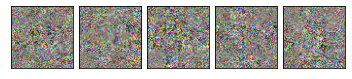

--- EPOCH 51/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 0.505880077679952
Generator loss:     0.8984248801710772


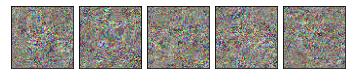

--- EPOCH 52/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.49213633603519863
Generator loss:     0.9121939503494423


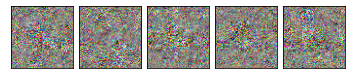

--- EPOCH 53/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.5247710247834524
Generator loss:     0.9294311047098669


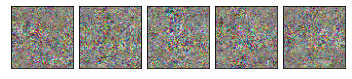

--- EPOCH 54/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.5630025135146247
Generator loss:     0.949518365920643


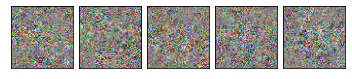

--- EPOCH 55/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.05it/s]
Discriminator loss: 0.48283764719963074
Generator loss:     0.9631217305366833


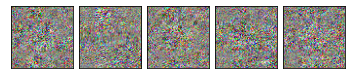

--- EPOCH 56/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.45338133970896405
Generator loss:     0.9772107828561007


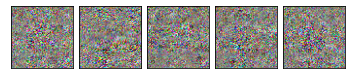

--- EPOCH 57/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.48379960987302995
Generator loss:     0.9950908595700417


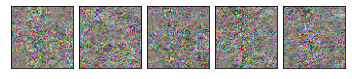

--- EPOCH 58/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 0.4951452381081051
Generator loss:     1.013562136741589


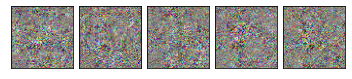

--- EPOCH 59/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.4899505277474721
Generator loss:     1.0298497886159677


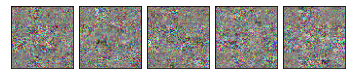

--- EPOCH 60/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.18it/s]
Discriminator loss: 0.43661606974071926
Generator loss:     1.049584999085076


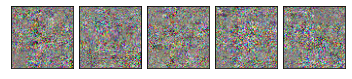

--- EPOCH 61/100 ---
100%|██████████| 9/9 [00:02<00:00,  3.92it/s]
Discriminator loss: 0.435268501440684
Generator loss:     1.0712402583893001


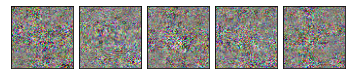

--- EPOCH 62/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.465542283323076
Generator loss:     1.0904949435005034


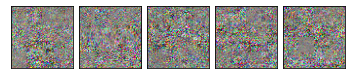

--- EPOCH 63/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.380856497420205
Generator loss:     1.1096650591332953


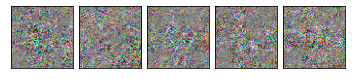

--- EPOCH 64/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.36729033788045246
Generator loss:     1.1279134711666954


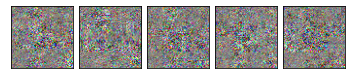

--- EPOCH 65/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.04it/s]
Discriminator loss: 0.33980945746103924
Generator loss:     1.1476151075321035


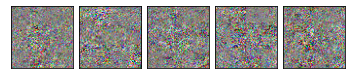

--- EPOCH 66/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 0.36990292370319366
Generator loss:     1.1602323442486675


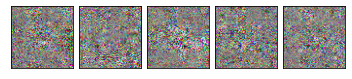

--- EPOCH 67/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.42it/s]
Discriminator loss: 0.35046403606732685
Generator loss:     1.188596089310909


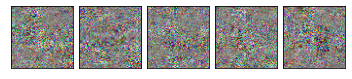

--- EPOCH 68/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.3907453980710771
Generator loss:     1.2031873073876833


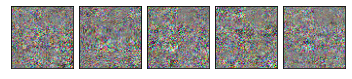

--- EPOCH 69/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.3748195982641644
Generator loss:     1.2306827541069958


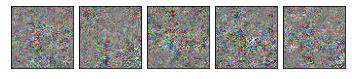

--- EPOCH 70/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.3324683838420444
Generator loss:     1.2547118758748934


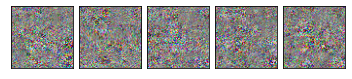

--- EPOCH 71/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.19it/s]
Discriminator loss: 0.3588710427284241
Generator loss:     1.263874903982553


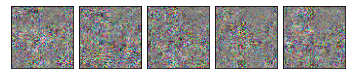

--- EPOCH 72/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.34938517544004655
Generator loss:     1.2892340620544982


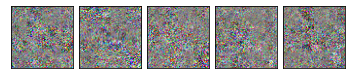

--- EPOCH 73/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.15it/s]
Discriminator loss: 0.37301520506540936
Generator loss:     1.3172174456496806


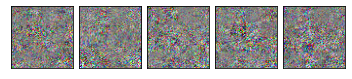

--- EPOCH 74/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.30138962467511493
Generator loss:     1.3381934692620683


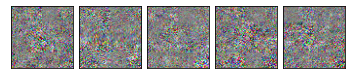

--- EPOCH 75/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.46it/s]
Discriminator loss: 0.30801086955600315
Generator loss:     1.3614727706560252


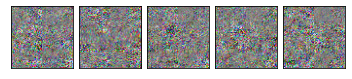

--- EPOCH 76/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
Discriminator loss: 0.2908263040913476
Generator loss:     1.3781612366358802


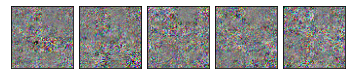

--- EPOCH 77/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.32it/s]
Discriminator loss: 0.2886349492602878
Generator loss:     1.4010258945086163


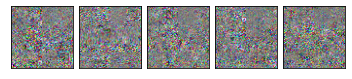

--- EPOCH 78/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.09it/s]
Discriminator loss: 0.29023277593983543
Generator loss:     1.422726574427758


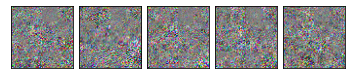

--- EPOCH 79/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.24998456239700317
Generator loss:     1.456186161197363


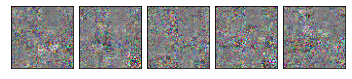

--- EPOCH 80/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
Discriminator loss: 0.24374504056241778
Generator loss:     1.4706147920362918


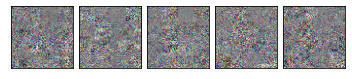

--- EPOCH 81/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.38it/s]
Discriminator loss: 0.2436378449201584
Generator loss:     1.4842176664664406


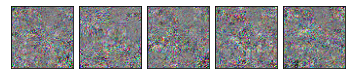

--- EPOCH 82/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.30it/s]
Discriminator loss: 0.29969484441810185
Generator loss:     1.518117810652361


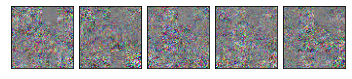

--- EPOCH 83/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.15it/s]
Discriminator loss: 0.25136428078015643
Generator loss:     1.527688793974108


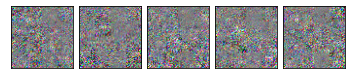

--- EPOCH 84/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
Discriminator loss: 0.21511336498790318
Generator loss:     1.5641674162617643


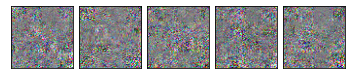

--- EPOCH 85/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
Discriminator loss: 0.2736691435178121
Generator loss:     1.5886923197259273


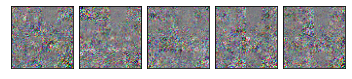

--- EPOCH 86/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
Discriminator loss: 0.23622221416897243
Generator loss:     1.6094173235855187


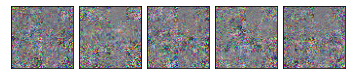

--- EPOCH 87/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.40it/s]
Discriminator loss: 0.1988726490073734
Generator loss:     1.639460265494629


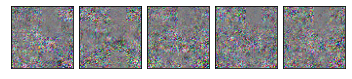

--- EPOCH 88/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.00it/s]
Discriminator loss: 0.2687518000602722
Generator loss:     1.6590684459221006


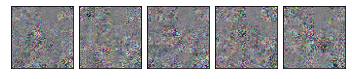

--- EPOCH 89/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
Discriminator loss: 0.13852309021684858
Generator loss:     1.684933120402455


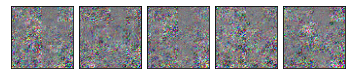

--- EPOCH 90/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.20it/s]
Discriminator loss: 0.1524152441157235
Generator loss:     1.7176858448071903


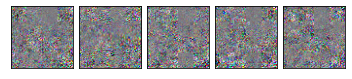

--- EPOCH 91/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.20723566164573035
Generator loss:     1.728613334819349


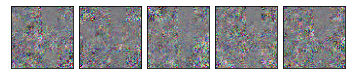

--- EPOCH 92/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.21it/s]
Discriminator loss: 0.23516672518518236
Generator loss:     1.759196767786659


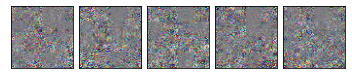

--- EPOCH 93/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.17it/s]
Discriminator loss: 0.18111048390467963
Generator loss:     1.808641332668527


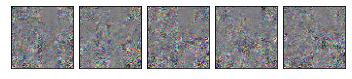

--- EPOCH 94/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.1396457859211498
Generator loss:     1.8298141678570525


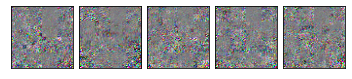

--- EPOCH 95/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.06it/s]
Discriminator loss: 0.11056552496221331
Generator loss:     1.84357206193411


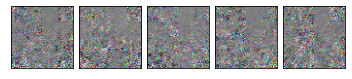

--- EPOCH 96/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.33it/s]
Discriminator loss: 0.1271323710680008
Generator loss:     1.8720079092650828


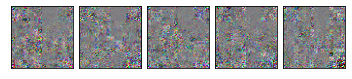

--- EPOCH 97/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.29it/s]
Discriminator loss: 0.1325955738623937
Generator loss:     1.902060754704139


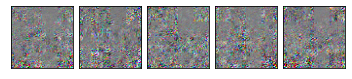

--- EPOCH 98/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
Discriminator loss: 0.23625038895342085
Generator loss:     1.9637996163251872


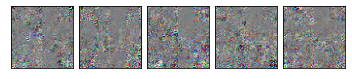

--- EPOCH 99/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.24it/s]
Discriminator loss: 0.1337339911195967
Generator loss:     1.9848503425971726


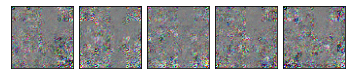

--- EPOCH 100/100 ---
100%|██████████| 9/9 [00:02<00:00,  4.26it/s]
Discriminator loss: 0.17917899787425995
Generator loss:     2.025834018686433


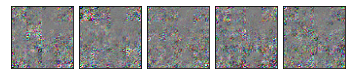

In [63]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


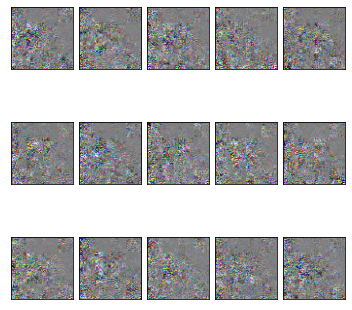

In [57]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [58]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [59]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [60]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [61]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

